In [1]:
import wrds
import pandas as pd
import numpy as np

In [2]:
conn = wrds.Connection(wrds_username='vidhiagrawal09')

Loading library list...
Done


### Data Collection

#### Top 800 Companies data with key financial variables

In [12]:
query_q="""WITH last_trading_days AS (
    SELECT
        DATE_TRUNC('quarter', dlycaldt) AS quarter,
        MAX(dlycaldt) AS last_date
    FROM crsp_a_stock.wrds_dsfv2_query
    WHERE dlycaldt BETWEEN '2013-01-01' AND '2023-12-31'
    GROUP BY DATE_TRUNC('quarter', dlycaldt)
),

ranked_companies AS (
    SELECT DISTINCT
        a.dlycaldt, a.dlycap, a.ticker, a.dlyprc, a.dlyprevprc, a.permno,
        ROW_NUMBER() OVER (PARTITION BY DATE_TRUNC('quarter', a.dlycaldt) ORDER BY a.dlycap DESC) AS rank
    FROM crsp_a_stock.wrds_dsfv2_query a
    JOIN last_trading_days b ON a.dlycaldt = b.last_date
    WHERE a.dlycap IS NOT NULL
),

top_600_companies AS (
    SELECT permno, dlycaldt, dlycap, ticker, dlyprc
    FROM ranked_companies
    WHERE rank <= 800
),

crsp_data AS (
    SELECT
        permno,
        dlycaldt,
        AVG(dlyvol) OVER (PARTITION BY permno ORDER BY dlycaldt ROWS BETWEEN 90 PRECEDING AND CURRENT ROW) AS avg_volume_3m,
        dlyprc AS stock_price,
        ((dlyprc - dlyprevprc) / NULLIF(dlyprevprc, 0)) * 100 AS return_1m
    FROM crsp_a_stock.wrds_dsfv2_query
    WHERE dlycaldt BETWEEN '2013-01-01' AND '2023-12-31'
    AND dlycap IS NOT NULL
),

crsp_ccm AS (
    SELECT
        gvkey,
        lpermno AS permno,
        linkdt,
        linkenddt
    FROM crsp.ccmxpf_linktable
    WHERE linktype IN ('LC', 'LU', 'LS')
    AND usedflag = 1
),

compustat_fundamentals AS (
    SELECT 
        gvkey,
        datadate,
        fyearq,
        fqtr,
        -- Use COALESCE to handle potential NULL values
        COALESCE(atq, atq_lags_1, atq_lags_2) AS total_assets,
        COALESCE(ltq, ltq_lags_1, ltq_lags_2) AS total_liabilities,
        COALESCE(niq, niq_lags_1, niq_lags_2) AS net_income,
        COALESCE(oibdpq, oibdpq_lags_1, oibdpq_lags_2) AS operating_income,
        COALESCE(subquery.oancfy, oancfq_lags_1, oancfq_lags_2) AS cash_flow_from_operations,
        
        -- Careful calculations with NULLIF to avoid division by zero
        CASE 
            WHEN COALESCE(actq, 0) > 0 AND COALESCE(lctq, 0) > 0 
            THEN actq / lctq 
            ELSE NULL 
        END AS current_ratio,
        
        CASE 
            WHEN COALESCE(ltq, 0) > 0 AND COALESCE(seqq, 0) > 0 
            THEN ltq / seqq 
            ELSE NULL 
        END AS debt_to_equity,
        
        CASE 
            WHEN COALESCE(atq, 0) > 0 
            THEN niq / atq 
            ELSE NULL 
        END AS roa,
        
        CASE 
            WHEN COALESCE(seqq, 0) > 0 
            THEN niq / seqq 
            ELSE NULL 
        END AS roe,
        
        COALESCE(epspiq, epspiq_lags_1, epspiq_lags_2) AS eps,
        
        CASE 
            WHEN COALESCE(seqq, 0) > 0 AND COALESCE(cshoq, 0) > 0 
            THEN seqq / cshoq 
            ELSE NULL 
        END AS book_value_per_share,
        
        cik
    FROM (
        SELECT 
            *,
            LAG(atq, 1) OVER (PARTITION BY gvkey ORDER BY datadate) AS atq_lags_1,
            LAG(atq, 2) OVER (PARTITION BY gvkey ORDER BY datadate) AS atq_lags_2,
            LAG(ltq, 1) OVER (PARTITION BY gvkey ORDER BY datadate) AS ltq_lags_1,
            LAG(ltq, 2) OVER (PARTITION BY gvkey ORDER BY datadate) AS ltq_lags_2,
            LAG(niq, 1) OVER (PARTITION BY gvkey ORDER BY datadate) AS niq_lags_1,
            LAG(niq, 2) OVER (PARTITION BY gvkey ORDER BY datadate) AS niq_lags_2,
            LAG(oibdpq, 1) OVER (PARTITION BY gvkey ORDER BY datadate) AS oibdpq_lags_1,
            LAG(oibdpq, 2) OVER (PARTITION BY gvkey ORDER BY datadate) AS oibdpq_lags_2,
            LAG(fundq.oancfy, 1) OVER (PARTITION BY gvkey ORDER BY datadate) AS oancfq_lags_1,
            LAG(fundq.oancfy, 2) OVER (PARTITION BY gvkey ORDER BY datadate) AS oancfq_lags_2,
            LAG(epspiq, 1) OVER (PARTITION BY gvkey ORDER BY datadate) AS epspiq_lags_1,
            LAG(epspiq, 2) OVER (PARTITION BY gvkey ORDER BY datadate) AS epspiq_lags_2
        FROM comp.fundq
        WHERE datadate BETWEEN '2013-01-01' AND '2023-12-31'
        AND indfmt = 'INDL'
        AND datafmt = 'STD'
        AND popsrc = 'D'
        AND consol = 'C'
    ) AS subquery
),

ibes_data AS (
    SELECT
        ticker,
        statpers,
        COUNT(DISTINCT numest) AS num_analysts_covering
    FROM ibes.statsum_epsus
    WHERE statpers BETWEEN '2013-01-01' AND '2023-12-31'
    GROUP BY ticker, statpers
),

auditor_changes AS (
    SELECT
        ac.company_fkey,
        COUNT(*) AS num_auditor_changes
    FROM audit_audit_comp.feed02_auditor_changes ac
    WHERE ac.file_date BETWEEN '2013-01-01' AND '2023-12-31'
    GROUP BY ac.company_fkey
),

financial_restatements AS (
    SELECT
        company_fkey,
        COUNT(*) AS num_restatements
    FROM audit_audit_comp.feed39_financial_restatements
    WHERE file_date BETWEEN '2013-01-01' AND '2023-12-31'
    GROUP BY company_fkey
)

-- Final merged query with more robust joining
SELECT
    cd.permno,
    cd.dlycaldt,
    cd.avg_volume_3m,
    cd.stock_price,
    cd.return_1m,
    tc.dlycap,
    tc.ticker,
    (SELECT DISTINCT FIRST_VALUE(ch.hsic) OVER (PARTITION BY ch.gvkey ORDER BY cf.datadate DESC)) as hsic,
    (SELECT DISTINCT FIRST_VALUE(ch.hgind) OVER (PARTITION BY ch.gvkey ORDER BY cf.datadate DESC)) as hgind,
    cf.total_assets,
    cf.total_liabilities,
    cf.net_income,
    cf.operating_income,
    cf.cash_flow_from_operations,
    cf.current_ratio,
    cf.debt_to_equity,
    cf.roa,
    cf.roe,
    cf.eps,
    cf.book_value_per_share,
    COALESCE(i.num_analysts_covering, 0) AS num_analysts_covering,
    COALESCE(ac.num_auditor_changes, 0) AS num_auditor_changes,
    COALESCE(fr.num_restatements, 0) AS num_restatements
FROM crsp_data cd
JOIN top_600_companies tc ON cd.permno = tc.permno
    AND cd.dlycaldt = tc.dlycaldt
JOIN crsp_ccm ccm ON cd.permno = ccm.permno
    AND cd.dlycaldt >= ccm.linkdt
    AND (cd.dlycaldt <= ccm.linkenddt OR ccm.linkenddt IS NULL)
JOIN compustat_fundamentals cf ON ccm.gvkey = cf.gvkey
    -- More flexible date matching using quarters
    AND DATE_TRUNC('quarter', cd.dlycaldt) = DATE_TRUNC('quarter', cf.datadate)
LEFT JOIN crsp_a_ccm.comphist ch ON ccm.gvkey = ch.gvkey
LEFT JOIN ibes_data i ON tc.ticker = i.ticker
    AND DATE_TRUNC('month', cd.dlycaldt) = DATE_TRUNC('month', i.statpers)
LEFT JOIN auditor_changes ac ON cf.cik = ac.company_fkey
LEFT JOIN financial_restatements fr ON cf.cik = fr.company_fkey
"""


def get_industry_name(sic_code):
    sic_str = str(int(sic_code))
    sic_4digit = int(sic_str) if len(sic_str) >= 4 else 0
    sic_3digit = int(sic_str[:3]) if len(sic_str) >= 3 else 0
    sic_2digit = int(sic_str[:2]) if len(sic_str) >= 2 else 0

    tech_sic_codes = {
        # Traditional Tech
        357: "Technology",    # Computer Hardware (e.g., Apple)
        737: "Technology",    # Software & Services (e.g., Microsoft)
        367: "Technology",    # Semiconductors
        366: "Technology",    # Communications Equipment

        # Internet & Digital Services
        5961: "Technology",   # E-commerce (e.g., Amazon)
        7375: "Technology",   # Information Retrieval Services (e.g., Google)
        7374: "Technology",   # Computer Processing (e.g., Meta/Facebook)
        7372: "Technology",   # Software Publishers
        4899: "Technology",   # Communications Services (e.g., Netflix)

        # Additional Tech Manufacturing
        3674: "Technology",   # Semiconductors & Related Devices
        3571: "Technology",   # Electronic Computers
        3577: "Technology",   # Computer Peripheral Equipment
    }

    # 4-digit SIC
    if sic_4digit in tech_sic_codes:
        return tech_sic_codes[sic_4digit]

    #  3-digit SIC
    if sic_3digit in tech_sic_codes:
        return tech_sic_codes[sic_3digit]

    # General industry classifications
    industry_mapping = {
        range(1, 10): "Agriculture, Forestry, Fishing",
        range(10, 15): "Mining",
        range(15, 18): "Construction",
        range(20, 40): "Manufacturing",
        range(40, 50): "Transportation & Public Utilities",
        range(50, 52): "Wholesale Trade",
        range(52, 60): "Retail Trade",
        range(60, 68): "Finance, Insurance, Real Estate",
        range(70, 90): "Services",
        range(90, 100): "Public Administration"
    }

    for sic_range, industry in industry_mapping.items():
        if sic_2digit in sic_range:
            return industry
    return "Unknown"

In [14]:
final_data= conn.raw_sql(query_q)
final_data= final_data.drop_duplicates(subset=['permno','dlycaldt'],keep='first')
final_data.loc[:, 'industry_name'] = final_data['hsic'].apply(get_industry_name)

In [27]:
final_data.groupby(['dlycaldt']).size()

dlycaldt
2013-03-28    799
2013-06-28    800
2013-09-30    798
2013-12-31    798
2014-03-31    799
2014-06-30    799
2014-09-30    800
2014-12-31    798
2015-03-31    798
2015-06-30    796
2015-09-30    797
2015-12-31    794
2016-03-31    796
2016-06-30    796
2016-09-30    796
2016-12-30    795
2017-03-31    795
2017-06-30    794
2017-09-29    794
2017-12-29    795
2018-03-29    794
2018-06-29    795
2018-09-28    794
2018-12-31    793
2019-03-29    794
2019-06-28    793
2019-09-30    795
2019-12-31    794
2020-03-31    792
2020-06-30    794
2020-09-30    793
2020-12-31    796
2021-03-31    795
2021-06-30    796
2021-09-30    796
2021-12-31    795
2022-03-31    796
2022-06-30    797
2022-09-30    792
2022-12-30    797
2023-03-31    796
2023-06-30    796
2023-09-29    795
2023-12-29    797
dtype: int64

#### S&P Quarterly Data Collection

In [30]:
import pandas as pd

# Fetch S&P 500 membership data with daily returns
sp500 = conn.raw_sql("""
    SELECT a.*, b.date, b.ret
    FROM crsp.dsp500list AS a
    JOIN crsp.dsf AS b
    ON a.permno = b.permno
    WHERE b.date >= a.start AND b.date <= a.ending
    AND b.date >= '2013-01-01' AND b.date <= '2023-12-31'
    ORDER BY b.date;
""", date_cols=['start', 'ending', 'date'])

# Identify the last trading day of each quarter
sp500['quarter'] = sp500['date'].dt.to_period('Q')
last_trading_days = sp500.groupby('quarter')['date'].max().reset_index()

# Filter S&P 500 data for the last trading day of each quarter
sp500_quarterly = pd.merge(sp500, last_trading_days, on='date')

# Add other identifiers from CRSP.MSENAMES
mse = conn.raw_sql("""
    SELECT comnam, ncusip, namedt, nameendt, 
           permno, shrcd, exchcd, hsiccd, ticker
    FROM crsp.msenames
""", date_cols=['namedt', 'nameendt'])

mse['nameendt'] = mse['nameendt'].fillna(pd.to_datetime('today'))

# Merge with S&P 500 data
sp500_quarterly_full = pd.merge(sp500_quarterly, mse, how='left', on='permno')
sp500_quarterly_full = sp500_quarterly_full.loc[
    (sp500_quarterly_full['date'] >= sp500_quarterly_full['namedt']) &
    (sp500_quarterly_full['date'] <= sp500_quarterly_full['nameendt'])
]

# Add Compustat Identifiers using CCM Linking Table
ccm = conn.raw_sql("""
    SELECT gvkey, liid AS iid, lpermno AS permno,
           linktype, linkprim, linkdt, linkenddt
    FROM crsp.ccmxpf_linktable
    WHERE SUBSTR(linktype, 1, 1) = 'L'
    AND (linkprim = 'C' OR linkprim = 'P')
""", date_cols=['linkdt', 'linkenddt'])

ccm['linkenddt'] = ccm['linkenddt'].fillna(pd.to_datetime('today'))

# Merge with S&P 500 quarterly data
sp500_quarterly_ccm = pd.merge(sp500_quarterly_full, ccm, how='left', on=['permno'])
sp500_quarterly_ccm = sp500_quarterly_ccm.loc[
    (sp500_quarterly_ccm['date'] >= sp500_quarterly_ccm['linkdt']) &
    (sp500_quarterly_ccm['date'] <= sp500_quarterly_ccm['linkenddt'])
]

# Drop unnecessary columns and rearrange for final output
sp500_quarterly_ccm = sp500_quarterly_ccm.drop(columns=[
    'namedt', 'nameendt', 'linktype', 'linkprim', 'linkdt', 'linkenddt'
])
sp500_quarterly_ccm = sp500_quarterly_ccm[[
    'date', 'permno', 'comnam', 'ncusip', 'shrcd', 'exchcd', 'hsiccd',
    'ticker', 'gvkey', 'iid', 'start', 'ending', 'ret'
]]

# Add CIKs and link with SEC Index Files using CIK
names = conn.raw_sql("""
    SELECT gvkey, cik, sic, naics, gind, gsubind
    FROM comp.names
""")
sp500_quarterly_cik = pd.merge(sp500_quarterly_ccm, names, on='gvkey', how='left')

# Display the final table
sp500_quarterly_cik.head()


,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret,cik,sic,naics,gind,gsubind
0,2013-03-28,79881,URBAN OUTFITTERS INC,91704710,11,3,5650,URBN,029150,01,2010-02-08,2017-03-17,-0.010220,0000912615,5651,458110,255040,25504010
1,2013-03-28,23819,HALLIBURTON CO,40621610,11,1,1389,HAL,005439,01,1957-03-01,2023-12-29,-0.006149,0000045012,1389,213112,101010,10101020
2,2013-03-28,14277,SCHLUMBERGER LTD,80685710,12,1,5651,SLB,009465,01,1965-03-04,2023-12-29,-0.002796,0000087347,1389,213112,101010,10101020
3,2013-03-28,59010,GAP INC,36476010,11,1,5651,GPS,004990,01,1986-08-21,2022-02-02,0.003686,0000039911,5651,458110,255040,25504010
4,2013-03-28,43449,MCDONALDS CORP,58013510,11,1,5812,MCD,007154,01,1970-06-25,2023-12-29,0.007988,0000063908,5812,722513,253010,25301040


In [31]:
sp500_quarterly_cik.groupby(['date']).size()

date
2013-03-28    501
2013-06-28    501
2013-09-30    501
2013-12-31    501
2014-03-31    501
2014-06-30    501
2014-09-30    501
2014-12-31    501
2015-03-31    501
2015-06-30    500
2015-09-30    501
2015-12-31    501
2016-03-31    501
2016-06-30    501
2016-09-30    501
2016-12-30    501
2017-03-31    501
2017-06-30    501
2017-09-29    501
2017-12-29    500
2018-03-29    501
2018-06-29    501
2018-09-28    501
2018-12-31    501
2019-03-29    501
2019-06-28    501
2019-09-30    501
2019-12-31    501
2020-03-31    501
2020-06-30    501
2020-09-30    501
2020-12-31    501
2021-03-31    500
2021-06-30    500
2021-09-30    500
2021-12-31    500
2022-03-31    500
2022-06-30    500
2022-09-30    499
2022-12-30    500
2023-03-31    500
2023-06-30    500
2023-09-29    500
2023-12-29    500
dtype: int64

In [32]:
sp500_quarterly_cik = sp500_quarterly_cik.drop_duplicates(subset=['permno','date'],keep='first')
sp500_quarterly_cik['In_S&P']=1
sp500_quarterly_cik.groupby(['date']).size()

date
2013-03-28    500
2013-06-28    500
2013-09-30    500
2013-12-31    500
2014-03-31    500
2014-06-30    500
2014-09-30    500
2014-12-31    500
2015-03-31    500
2015-06-30    499
2015-09-30    500
2015-12-31    500
2016-03-31    500
2016-06-30    500
2016-09-30    500
2016-12-30    500
2017-03-31    500
2017-06-30    500
2017-09-29    500
2017-12-29    499
2018-03-29    500
2018-06-29    500
2018-09-28    500
2018-12-31    500
2019-03-29    500
2019-06-28    500
2019-09-30    500
2019-12-31    500
2020-03-31    500
2020-06-30    500
2020-09-30    500
2020-12-31    500
2021-03-31    500
2021-06-30    500
2021-09-30    500
2021-12-31    500
2022-03-31    500
2022-06-30    500
2022-09-30    499
2022-12-30    500
2023-03-31    500
2023-06-30    500
2023-09-29    500
2023-12-29    500
dtype: int64

### Join S&P and Top 800 Companies data

In [34]:
import pandas as pd

# Load your datasets (assuming you have already imported them as `top600` and `sp500`)
# Ensure date columns are datetime
final_data['dlycaldt'] = pd.to_datetime(final_data['dlycaldt'])
sp500_quarterly_cik['date'] = pd.to_datetime(sp500_quarterly_cik['date'])

# Perform a left join on 'permno' and 'dlycaldt'/'date'
merged = pd.merge(final_data, sp500_quarterly_cik, 
                  left_on=['permno', 'dlycaldt'], 
                  right_on=['permno', 'date'], 
                  how='left')

# Add a binary column 'in_sp500'
merged['in_sp500'] = merged['In_S&P'].notna().astype(int)

# # Drop unnecessary columns from the S&P data (optional)
columns_to_drop = ['In_S&P', 'date', 'comnam', 'ncusip', 'shrcd', 'exchcd', 'hsiccd', 
                   'gvkey', 'iid', 'start', 'ending', 'ret', 'cik', 'sic', 'naics', 
                   'gind', 'gsubind','hsic','hgind']
merged = merged.drop(columns=columns_to_drop, errors='ignore')

# Save or inspect the merged dataset
print(merged.head())

   permno   dlycaldt  avg_volume_3m  stock_price  return_1m       dlycap  \
0   87432 2013-03-28   3.477558e+06        41.97  -0.285103  14570263.23   
1   87432 2013-06-28   3.722482e+06        42.76  -0.742804  14729793.76   
2   87432 2013-09-30   2.904071e+06        51.25  -0.736006  16953090.00   
3   87432 2013-12-31   2.475560e+06        57.19  -0.226797  18976156.71   
4   87432 2014-03-31   2.614428e+06        55.92   2.249040  18644902.32   

  ticker_x  total_assets  total_liabilities  net_income  ...       roa  \
0        A       10653.0             5302.0       179.0  ...  0.016803   
1        A       10587.0             5279.0       166.0  ...  0.015680   
2        A       10278.0             5488.0       168.0  ...  0.016346   
3        A       10686.0             5397.0       211.0  ...  0.019745   
4        A       10638.0             5191.0       195.0  ...  0.018331   

        roe   eps  book_value_per_share  num_analysts_covering  \
0  0.033470  0.52             15

In [39]:
merged.groupby(['dlycaldt']).size()

dlycaldt
2013-03-28    799
2013-06-28    800
2013-09-30    798
2013-12-31    798
2014-03-31    799
2014-06-30    799
2014-09-30    800
2014-12-31    798
2015-03-31    798
2015-06-30    796
2015-09-30    797
2015-12-31    794
2016-03-31    796
2016-06-30    796
2016-09-30    796
2016-12-30    795
2017-03-31    795
2017-06-30    794
2017-09-29    794
2017-12-29    795
2018-03-29    794
2018-06-29    795
2018-09-28    794
2018-12-31    793
2019-03-29    794
2019-06-28    793
2019-09-30    795
2019-12-31    794
2020-03-31    792
2020-06-30    794
2020-09-30    793
2020-12-31    796
2021-03-31    795
2021-06-30    796
2021-09-30    796
2021-12-31    795
2022-03-31    796
2022-06-30    797
2022-09-30    792
2022-12-30    797
2023-03-31    796
2023-06-30    796
2023-09-29    795
2023-12-29    797
dtype: int64

In [41]:
merged['in_sp500'].value_counts(normalize=True)

in_sp500
1    0.573346
0    0.426654
Name: proportion, dtype: float64

In [43]:
merged.shape

(35012, 24)

In [45]:
merged.columns

Index(['permno', 'dlycaldt', 'avg_volume_3m', 'stock_price', 'return_1m',
       'dlycap', 'ticker_x', 'total_assets', 'total_liabilities', 'net_income',
       'operating_income', 'cash_flow_from_operations', 'current_ratio',
       'debt_to_equity', 'roa', 'roe', 'eps', 'book_value_per_share',
       'num_analysts_covering', 'num_auditor_changes', 'num_restatements',
       'industry_name', 'ticker_y', 'in_sp500'],
      dtype='object')

In [47]:
merged.isnull().sum()

permno                           0
dlycaldt                         0
avg_volume_3m                    0
stock_price                      0
return_1m                        3
dlycap                           0
ticker_x                         0
total_assets                  4157
total_liabilities             4159
net_income                    4155
operating_income              6484
cash_flow_from_operations     4216
current_ratio                 9768
debt_to_equity                5516
roa                           4304
roe                           5524
eps                           4159
book_value_per_share          5531
num_analysts_covering            0
num_auditor_changes              0
num_restatements                 0
industry_name                    0
ticker_y                     14938
in_sp500                         0
dtype: int64

In [49]:
merged.columns

Index(['permno', 'dlycaldt', 'avg_volume_3m', 'stock_price', 'return_1m',
       'dlycap', 'ticker_x', 'total_assets', 'total_liabilities', 'net_income',
       'operating_income', 'cash_flow_from_operations', 'current_ratio',
       'debt_to_equity', 'roa', 'roe', 'eps', 'book_value_per_share',
       'num_analysts_covering', 'num_auditor_changes', 'num_restatements',
       'industry_name', 'ticker_y', 'in_sp500'],
      dtype='object')

<Figure size 2000x1600 with 0 Axes>

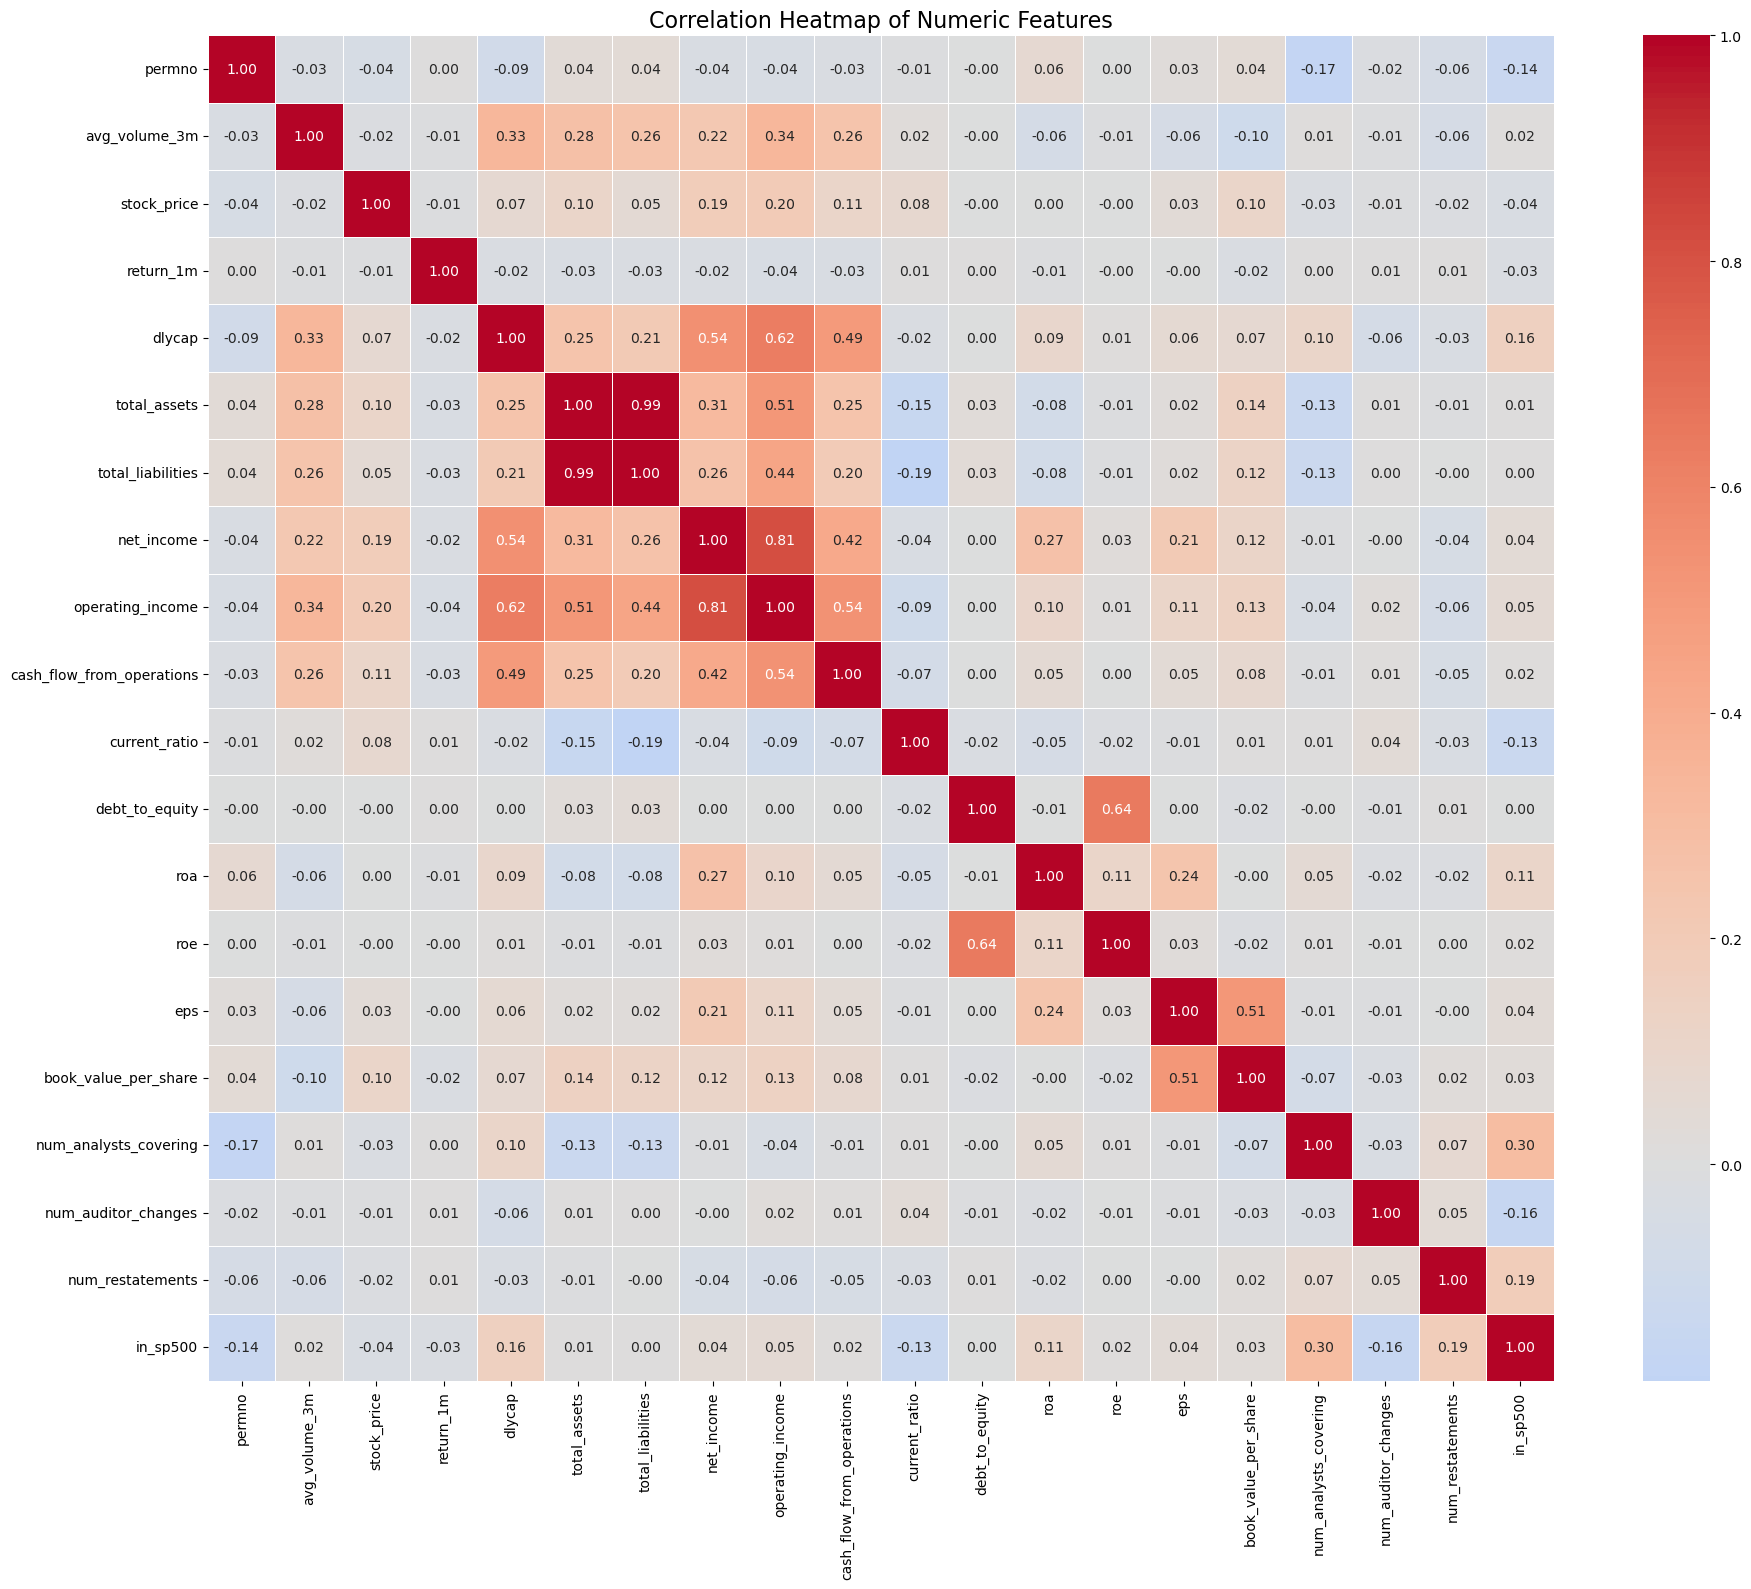

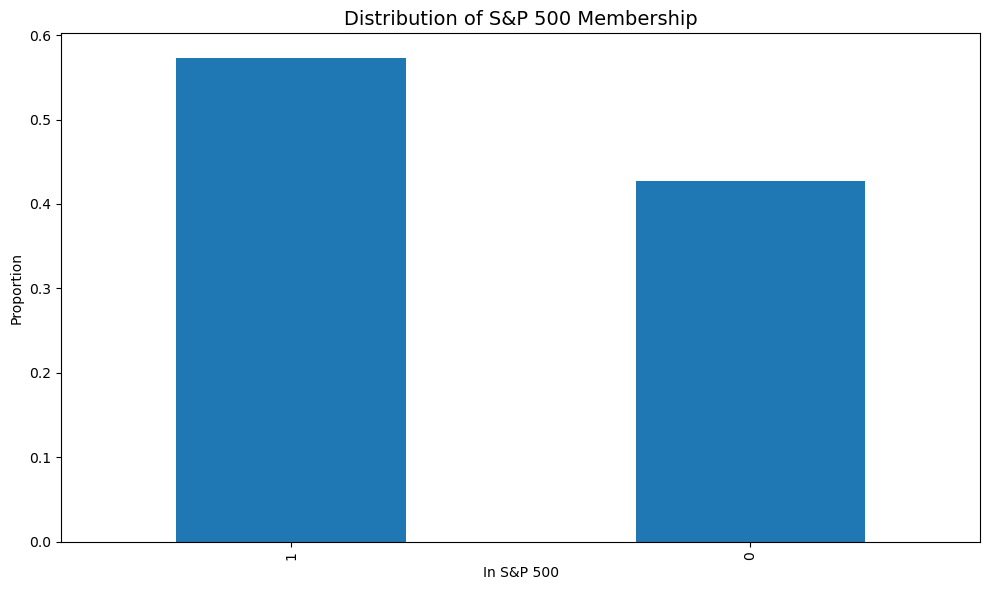

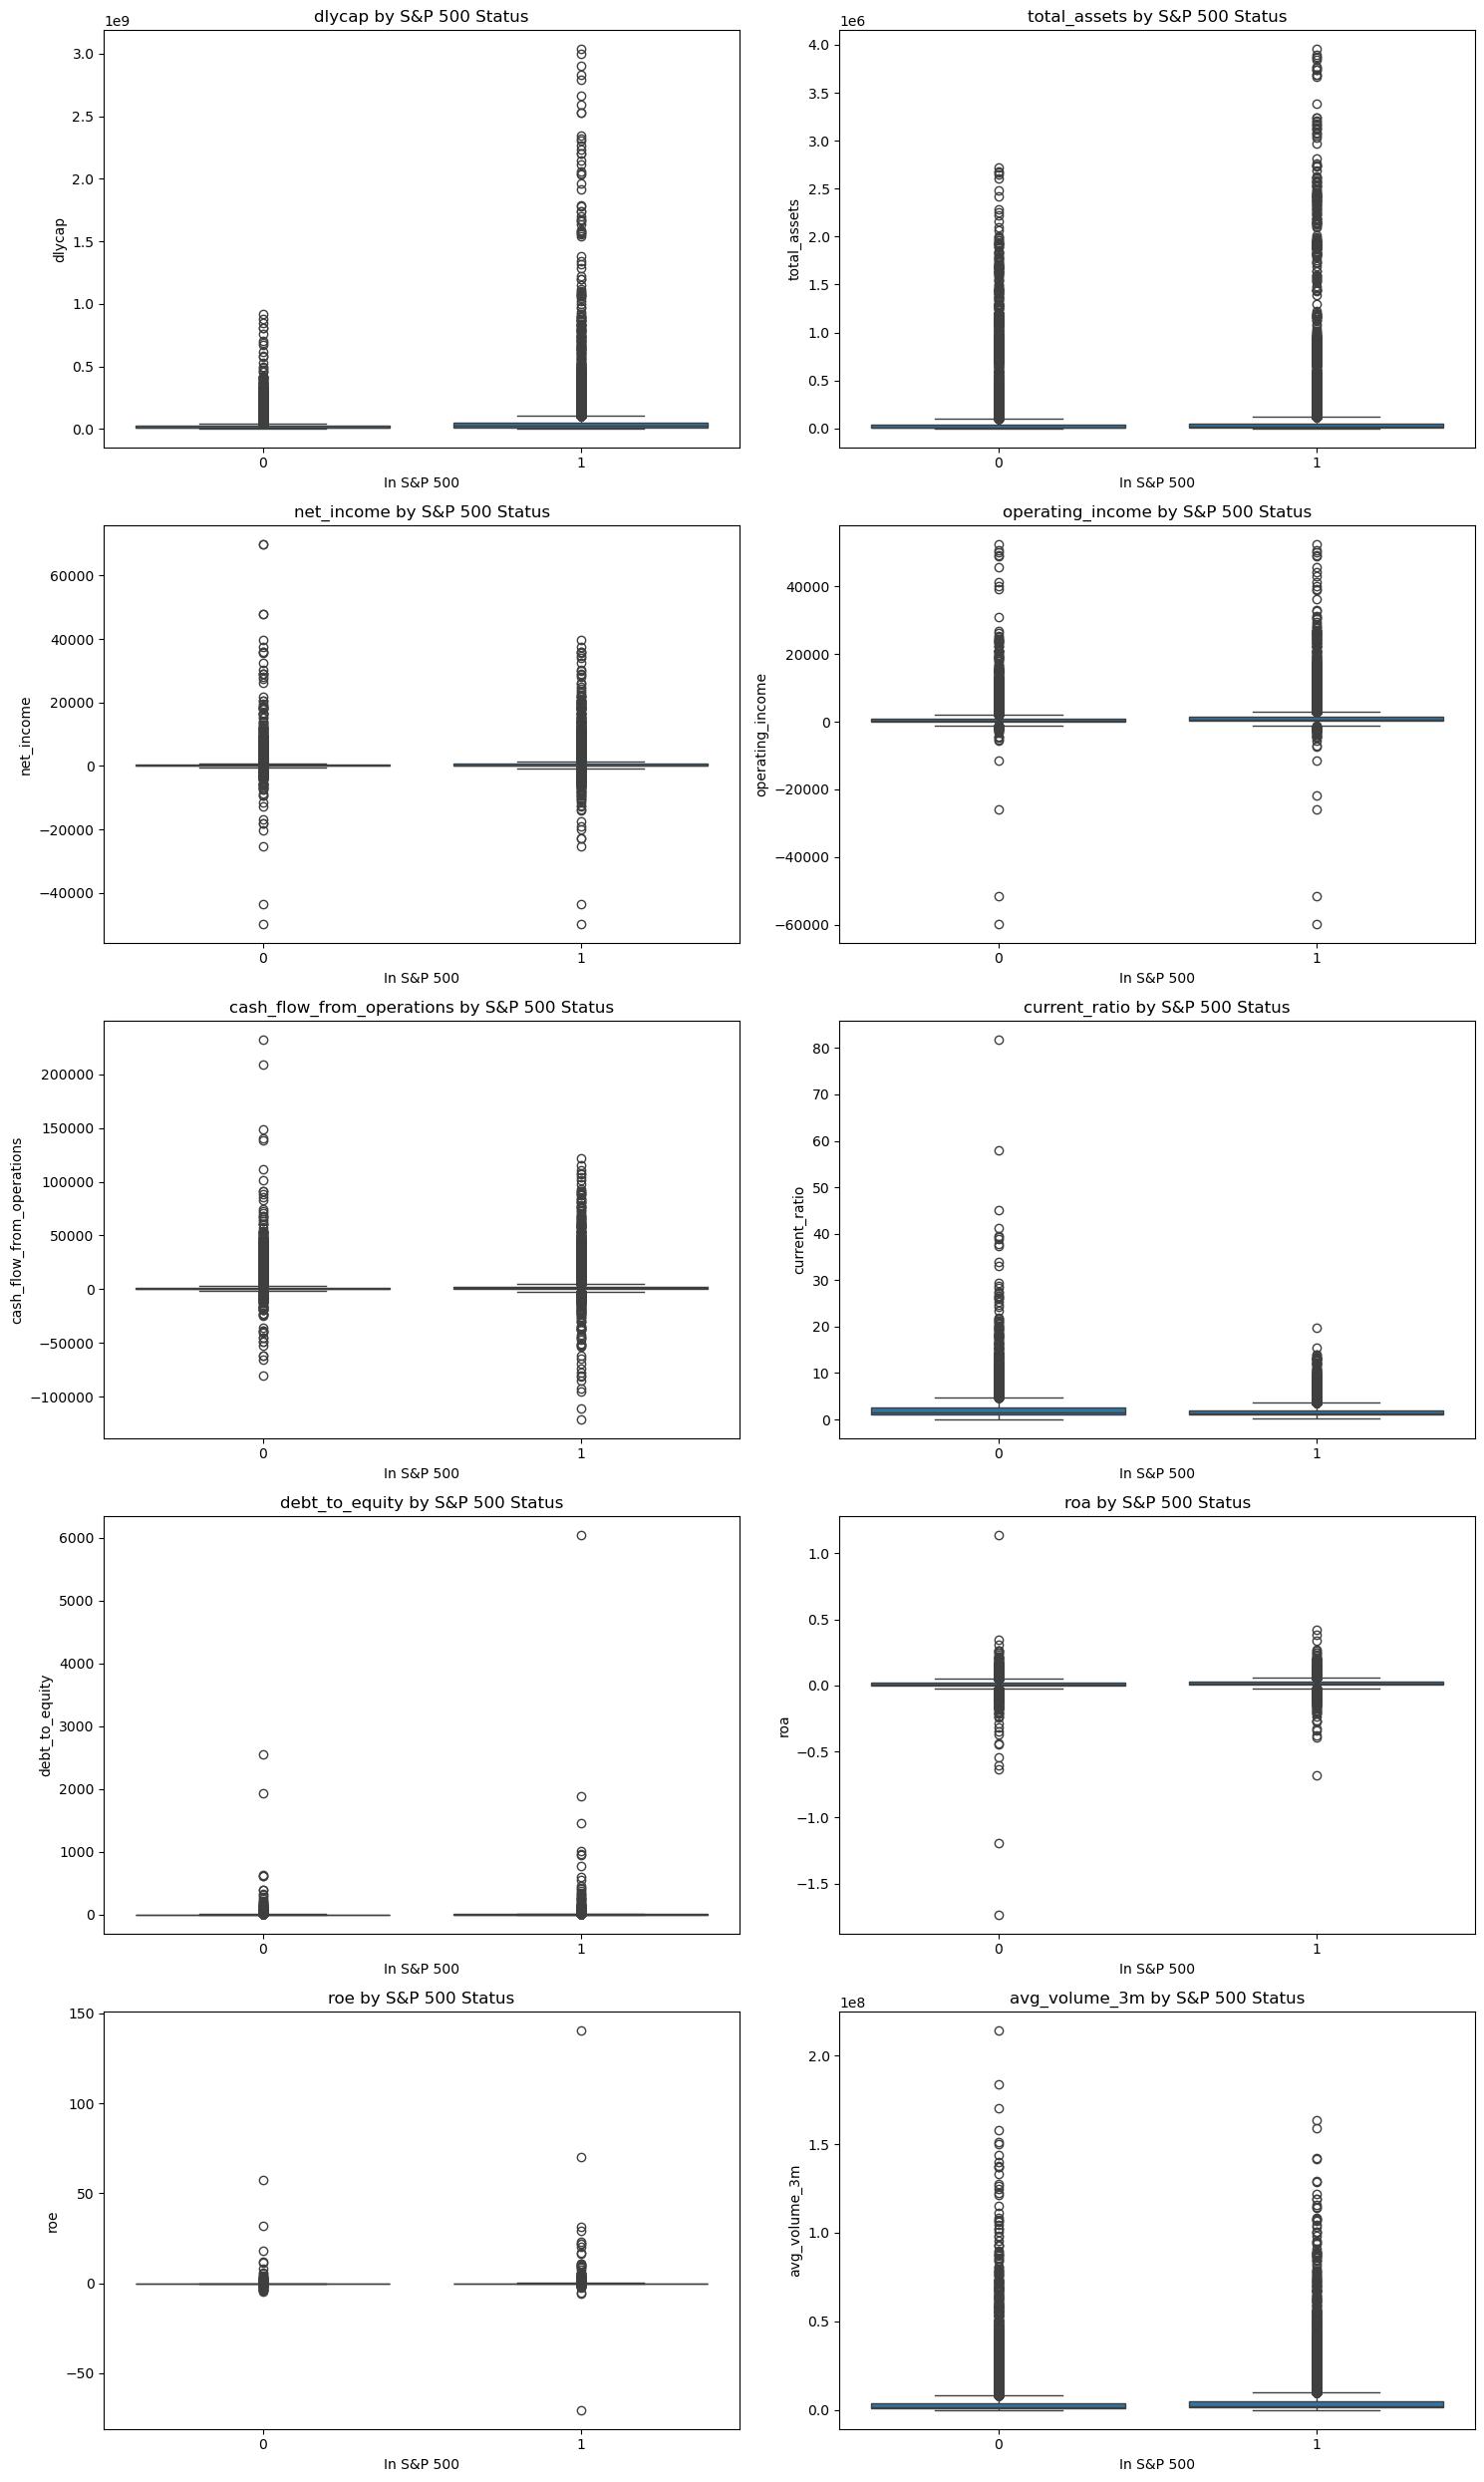

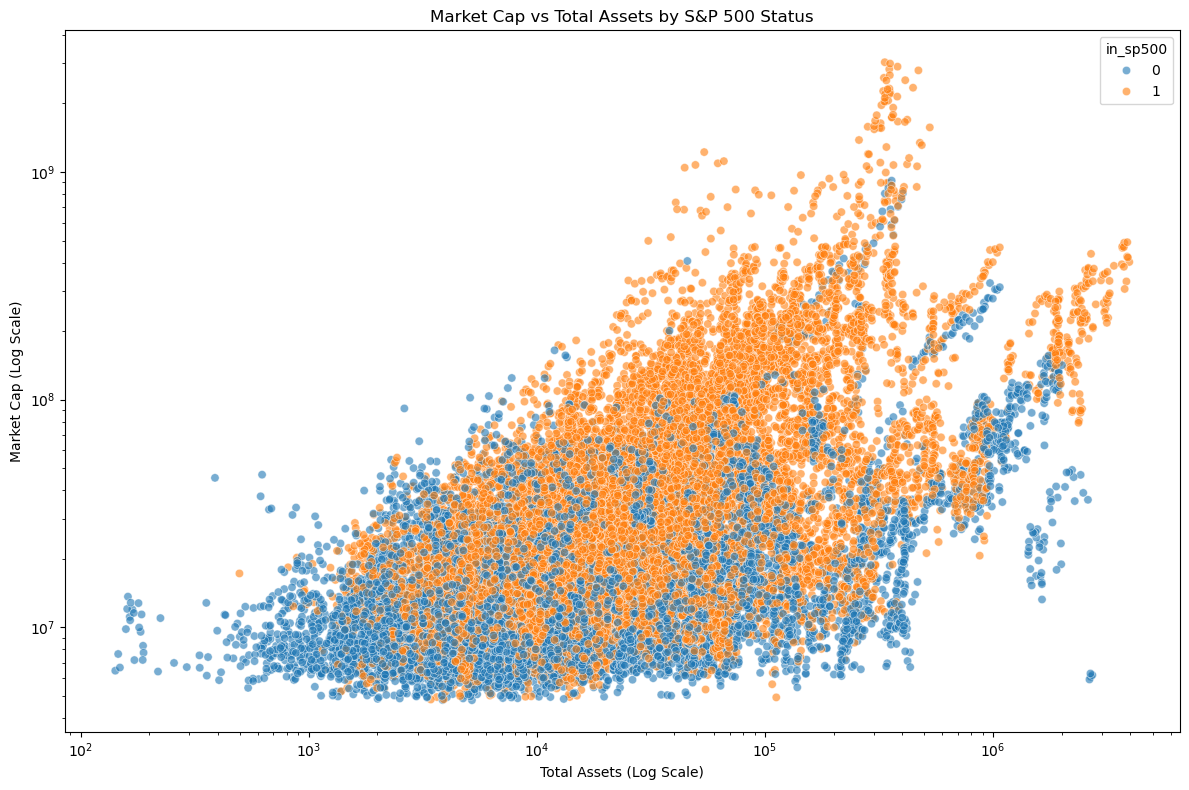

<Figure size 1500x800 with 0 Axes>

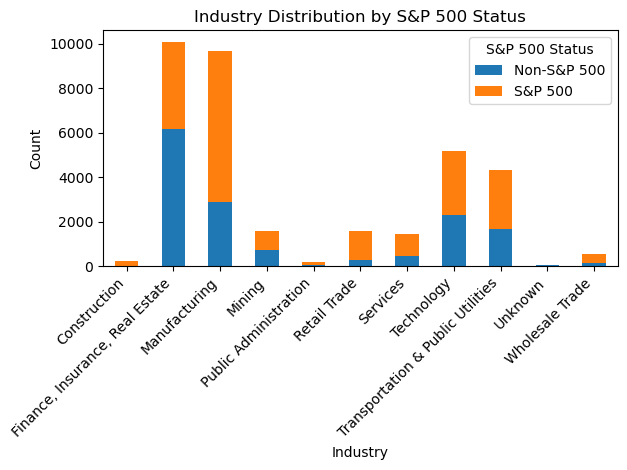

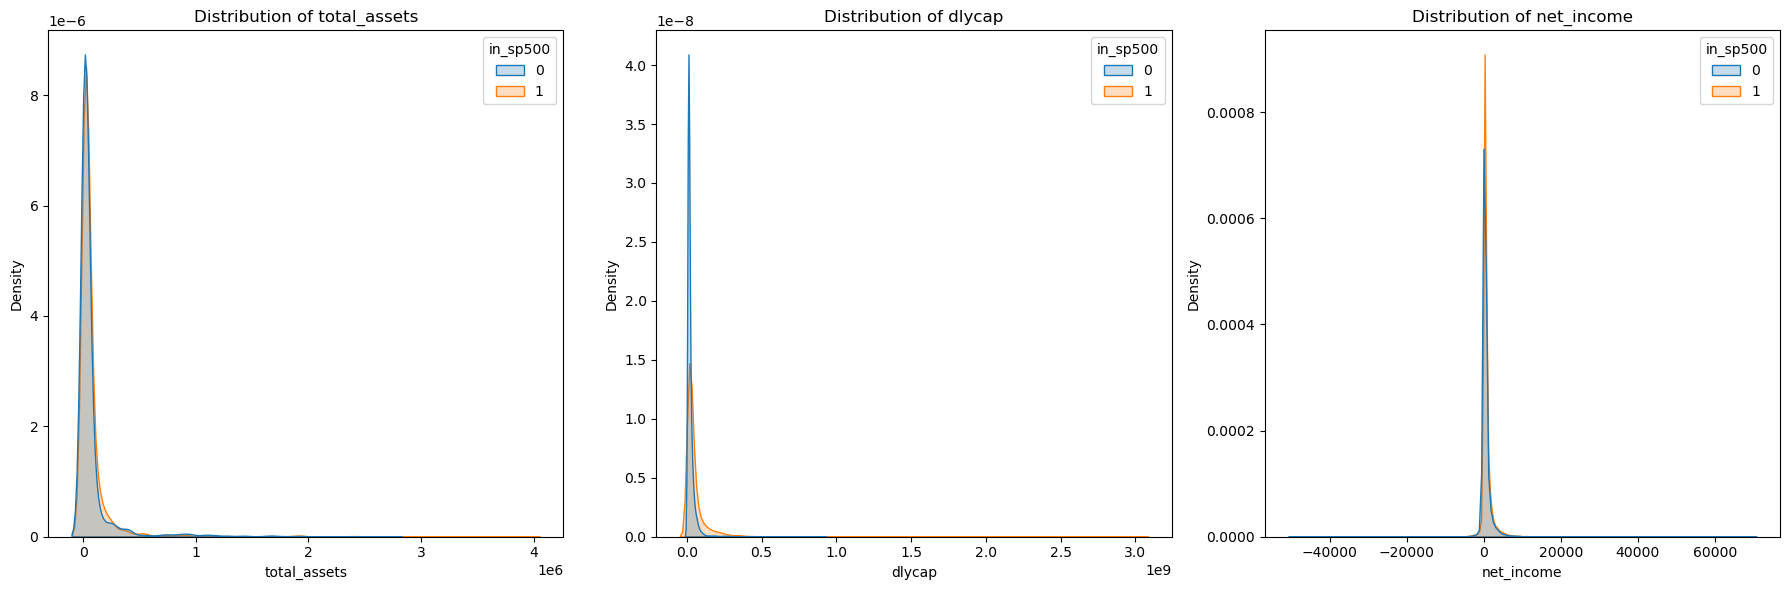

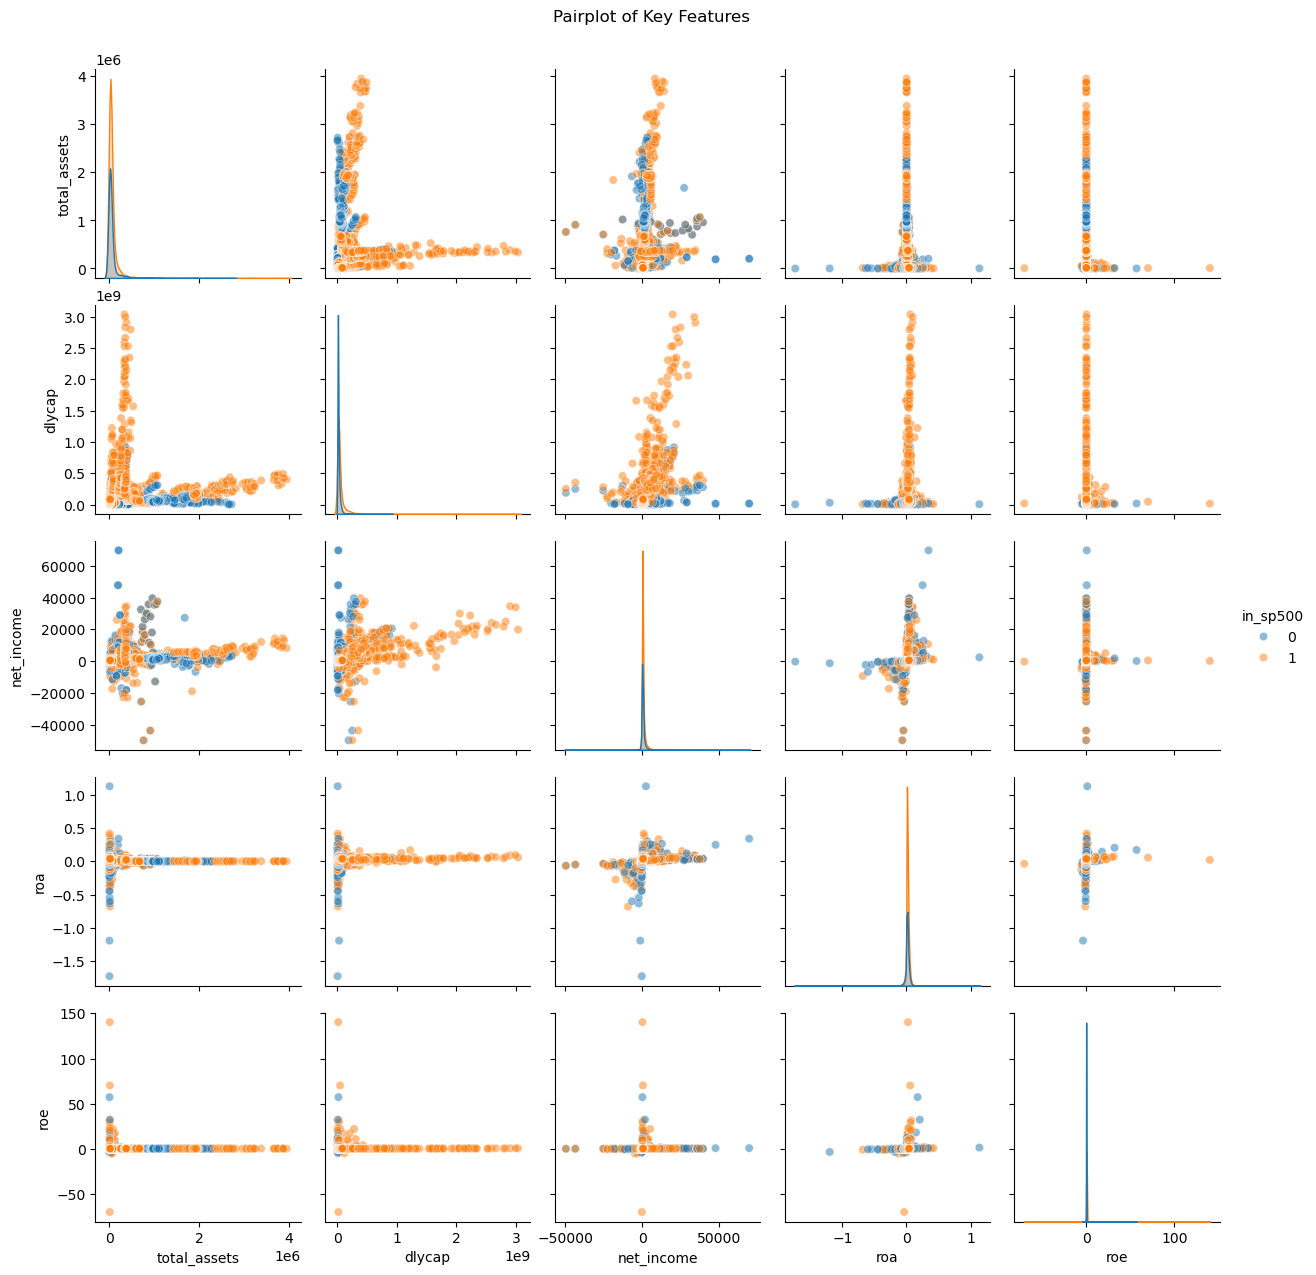

Visualizations have been saved in the 'sp500_visualizations' directory.

Dataset Statistics:
Total initial datapoints: 35012
Number of records with insp500=1: 20074

Industry Distribution:
in_sp500                              0     1
industry_name                                
Construction                         40   211
Finance, Insurance, Real Estate    6196  3912
Manufacturing                      2906  6757
Mining                              722   852
Public Administration                81   123
Retail Trade                        284  1324
Services                            485   971
Technology                         2324  2859
Transportation & Public Utilities  1666  2666
Unknown                              60     2
Wholesale Trade                     174   397


In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

def create_comprehensive_visualizations(merged_df):
    """
    Generate comprehensive visualizations for S&P 500 entry prediction project
    
    Parameters:
    -----------
    merged_df : pandas.DataFrame
        Merged dataset with features and S&P 500 entry indicator
    """
    # Create output directory if it doesn't exist
    os.makedirs('sp500_visualizations', exist_ok=True)
    
    # 1. Correlation Heatmap
    plt.figure(figsize=(20, 16))
    numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
    correlation_matrix = merged_df[numeric_columns].corr()
    
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                linewidths=0.5, 
                fmt='.2f', 
                square=True, 
                center=0)
    plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
    plt.tight_layout()
    plt.savefig('sp500_visualizations/1_correlation_heatmap.png')
    plt.show()
    
    # 2. Distribution of S&P 500 Entry
    plt.figure(figsize=(10, 6))
    merged_df['in_sp500'].value_counts(normalize=True).plot(kind='bar')
    plt.title('Distribution of S&P 500 Membership', fontsize=14)
    plt.xlabel('In S&P 500')
    plt.ylabel('Proportion')
    plt.tight_layout()
    plt.savefig('sp500_visualizations/2_sp500_distribution.png')
    plt.show()
    
    # 3. Box Plots of Key Financial Metrics by S&P 500 Status
    financial_metrics = [
        'dlycap', 'total_assets', 'net_income', 
        'operating_income', 'cash_flow_from_operations', 
        'current_ratio', 'debt_to_equity', 
        'roa', 'roe', 'avg_volume_3m'
    ]
    
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))
    axes = axes.ravel()
    
    for i, metric in enumerate(financial_metrics):
        sns.boxplot(x='in_sp500', y=metric, data=merged_df, ax=axes[i])
        axes[i].set_title(f'{metric} by S&P 500 Status')
        axes[i].set_xlabel('In S&P 500')
        axes[i].set_ylabel(metric)
    
    plt.tight_layout()
    plt.savefig('sp500_visualizations/3_financial_metrics_boxplots.png')
    plt.show()
    
    # 4. Scatter Plot of Total Assets vs Market Cap
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=merged_df, 
        x='total_assets', 
        y='dlycap', 
        hue='in_sp500',
        alpha=0.6
    )
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Market Cap vs Total Assets by S&P 500 Status')
    plt.xlabel('Total Assets (Log Scale)')
    plt.ylabel('Market Cap (Log Scale)')
    plt.tight_layout()
    plt.savefig('sp500_visualizations/4_assets_marketcap_scatter.png')
    plt.show()
    
    # 5. Industry Distribution
    plt.figure(figsize=(15, 8))
    industry_sp500 = merged_df.groupby(['industry_name', 'in_sp500']).size().unstack(fill_value=0)
    industry_sp500.plot(kind='bar', stacked=True)
    plt.title('Industry Distribution by S&P 500 Status')
    plt.xlabel('Industry')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='S&P 500 Status', labels=['Non-S&P 500', 'S&P 500'])
    plt.tight_layout()
    plt.savefig('sp500_visualizations/5_industry_distribution.png')
    plt.show()
    
    # 6. Density Plot of Key Financial Metrics
    metrics_to_plot = ['total_assets', 'dlycap', 'net_income']
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
    for i, metric in enumerate(metrics_to_plot):
        sns.kdeplot(
            data=merged_df, 
            x=metric, 
            hue='in_sp500', 
            fill=True, 
            common_norm=False,
            ax=axes[i]
        )
        axes[i].set_title(f'Distribution of {metric}')
    
    plt.tight_layout()
    plt.savefig('sp500_visualizations/6_density_plots.png')
    plt.show()
    
    # 7. Pair Plot of Key Features (with error handling)
    try:
        key_features = ['total_assets', 'dlycap', 'net_income', 
                        'roa', 'roe', 'in_sp500']
        g = sns.pairplot(merged_df[key_features], 
                         hue='in_sp500', 
                         plot_kws={'alpha': 0.5})
        g.fig.suptitle('Pairplot of Key Features', y=1.02)
        g.savefig('sp500_visualizations/7_pairplot.png')
        plt.show()
    except Exception as e:
        print(f"Error creating pairplot: {e}")
    
    # Print diagnostic information
    print("Visualizations have been saved in the 'sp500_visualizations' directory.")
    
    # Print some basic statistics about the dataset
    print("\nDataset Statistics:")
    print(f"Total initial datapoints: {len(merged_df)}")
    print(f"Number of records with insp500=1: {merged_df['in_sp500'].sum()}")

    # Print industry distribution
    print("\nIndustry Distribution:")
    industry_counts = merged_df.groupby(['industry_name', 'in_sp500']).size().unstack(fill_value=0)
    print(industry_counts)

# Call the function with your merged dataframe
create_comprehensive_visualizations(merged)

In [57]:
merged.columns

Index(['permno', 'dlycaldt', 'avg_volume_3m', 'stock_price', 'return_1m',
       'dlycap', 'ticker_x', 'total_assets', 'total_liabilities', 'net_income',
       'operating_income', 'cash_flow_from_operations', 'current_ratio',
       'debt_to_equity', 'roa', 'roe', 'eps', 'book_value_per_share',
       'num_analysts_covering', 'num_auditor_changes', 'num_restatements',
       'industry_name', 'ticker_y', 'in_sp500'],
      dtype='object')

In [59]:
merged.head()

,permno,dlycaldt,avg_volume_3m,stock_price,return_1m,dlycap,ticker_x,total_assets,total_liabilities,net_income,...,roa,roe,eps,book_value_per_share,num_analysts_covering,num_auditor_changes,num_restatements,industry_name,ticker_y,in_sp500
0,87432,2013-03-28,3.477558e+06,41.97,-0.285103,14570263.23,A,10653.0,5302.0,179.0,...,0.016803,0.033470,0.52,15.405045,0,0,10,Manufacturing,A,1
1,87432,2013-06-28,3.722482e+06,42.76,-0.742804,14729793.76,A,10587.0,5279.0,166.0,...,0.015680,0.031291,0.48,15.400202,0,0,10,Manufacturing,A,1
2,87432,2013-09-30,2.904071e+06,51.25,-0.736006,16953090.00,A,10278.0,5488.0,168.0,...,0.016346,0.035095,0.50,14.462236,0,0,10,Manufacturing,A,1
3,87432,2013-12-31,2.475560e+06,57.19,-0.226797,18976156.71,A,10686.0,5397.0,211.0,...,0.019745,0.039917,0.64,15.907361,0,0,10,Manufacturing,A,1
4,87432,2014-03-31,2.614428e+06,55.92,2.249040,18644902.32,A,10638.0,5191.0,195.0,...,0.018331,0.035819,0.59,16.327706,0,0,10,Manufacturing,A,1


In [61]:
merged.shape

(35012, 24)

In [65]:
print("1. Basic Statistical Summary")
numerical_columns = merged.select_dtypes(include=[np.number]).columns
print(merged[numerical_columns].describe())

1. Basic Statistical Summary
             permno  avg_volume_3m    stock_price     return_1m        dlycap  \
count  35012.000000   3.501200e+04   35012.000000  35009.000000  3.501200e+04   
mean   59081.058551   4.540244e+06     501.291628      0.159466  4.135320e+07   
std    31108.739135   9.160294e+06   11533.283242      1.524159  9.814544e+07   
min    10104.000000   2.434176e+02       2.360000    -27.762431  4.779216e+06   
25%    22517.000000   9.775101e+05      43.860000     -0.605857  1.128921e+07   
50%    75592.000000   1.966675e+06      73.675000      0.097267  1.847524e+07   
75%    87717.000000   4.279247e+06     125.290000      0.874126  3.719426e+07   
max    93436.000000   2.140249e+08  542625.000000     22.974057  3.035217e+09   

       total_assets  total_liabilities    net_income  operating_income  \
count  3.085500e+04       3.085300e+04  30857.000000      28528.000000   
mean   7.766716e+04       6.087158e+04    594.663412       1326.662954   
std    2.408015e+05

In [67]:
industry_summary = merged.groupby('industry_name').agg({
    'dlycap': 'mean',
    'return_1m': 'mean',
    'roa': 'mean',
    'roe': 'mean',
    'num_analysts_covering': 'mean',
    'num_auditor_changes': 'sum',
    'num_restatements': 'sum'
}).round(2)

In [69]:
industry_summary

,dlycap,return_1m,roa,roe,num_analysts_covering,num_auditor_changes,num_restatements
industry_name,,,,,,,
Construction,1.444110e+07,0.05,0.02,0.05,2.19,46,300
"Finance, Insurance, Real Estate",3.411720e+07,0.06,0.01,0.04,1.13,737,5486
Manufacturing,4.018183e+07,0.20,0.02,0.08,3.39,1879,10903
Mining,2.526626e+07,0.23,0.01,0.01,3.29,308,799
Public Administration,1.520330e+08,0.08,0.01,0.02,2.02,99,146
Retail Trade,4.609805e+07,0.03,0.03,0.19,4.14,45,1048
Services,2.544856e+07,0.26,0.02,0.26,2.10,354,1531
Technology,7.234003e+07,0.20,0.02,0.07,3.25,922,3289
Transportation & Public Utilities,3.275685e+07,0.27,0.01,0.04,2.99,816,3054
